<a href="https://colab.research.google.com/github/regifukuchi/UFABC_UofC_datasets/blob/main/notebooks/BMC_RIC_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Three-dimensional kinematics dataset of running - interlaboratory comparison

> Reginaldo K Fukuchi, Marcos Duarte and Reed Ferber

This dataset is located on figshare, however it is not easy to run this notebook in the cloud and load the data from figshare repository (although there is a figshare API).  

To make it possible to run this notebook in the cloud, the data will be loaded from a copy in the GitHub repository (the dataset is small enough to be stored on GitHub).

## Setup

In [1]:
#@title ### import libraries {display-mode: "form"}

import sys, os, glob, datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# import/install less common libraries
try:
    import pingouin as pg
except:
    !pip install -q pingouin
    import pingouin as pg
try:
    import spm1d
except:
    !pip install -q spm1d
    import spm1d
try:
    %matplotlib widget
except:
    !pip install -q ipympl
    %matplotlib widget

if os.getenv("COLAB_RELEASE_TAG"):
    from google.colab import output
    output.enable_custom_widget_manager()

import warnings
warnings.filterwarnings("ignore")

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' pandas {pd.__version__}', f' pingouin {pg.__version__}', f' spm1d {spm1d.__version__}',
      datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)] on win32
 numpy 1.26.0
 pandas 2.0.3
 pingouin 0.5.4
 spm1d 0.4.22 (2023-10-24)
30/04/2024 00:56:38


### Configuration

In [2]:
#@title #### Plot style {display-mode: "form"}
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 1})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
pd.set_option('display.precision', 3)
sty_center_header = [dict(selector="th", props=[("text-align", "center")])]

import warnings
warnings.filterwarnings("ignore")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Dataset location

In [3]:
#@title #### Path {display-mode: "form"}
# LOCAL
path2 = Path('../data')
os_sep = os.sep
metadata_fname = 'metadata.txt'
if not os.path.isfile(path2 / metadata_fname):
    path2 = Path('data')
    if not os.path.isfile(path2 / metadata_fname):
        path2 = Path('.')
        if not os.path.isfile(path2 / metadata_fname):
            print('Dataset not found locally. It will be loaded from the GitHub repo.')
            # REMOTE
            path2 = 'https://raw.githubusercontent.com/BMClab/datasets/master/BMC_RIC/data'
            os_sep = '/'

path2 = str(path2)
print(f'Dataset location: {path2}')

Dataset not found locally. It will be loaded from the GitHub repo.
Dataset location: https://raw.githubusercontent.com/BMClab/datasets/master/BMC_RIC/data


## Helping functions

In [4]:
#@title #### Functions {display-mode: "form"}

def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats = pd.concat([stats, stat], axis=0)
    stats.drop(columns=['BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'T': '{:.3f}', 'p-val': '{:.3f}', 'cohen-d': '{:.3f}'}
                              ).apply(sig_red, subset='p-val', axis=1))
    return stats

def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    is_sig = col < alpha
    return ['color: red' if x else 'color: None' for x in is_sig]

def describe(df, by, var=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    display(x.style.apply(sig_red,
                          subset=[col for col in x.columns if col[1] == 'normality'])
                   .format(lambda y: f'{y:.0f}' if int(y)==y else f'{y:.3f}').set_table_styles(sty_center_header))
    return x

## Load metadata

In [5]:
#@title #### Metadata {display-mode: "form"}
metadata = pd.read_csv(f'{path2}{os_sep}{metadata_fname}', sep='\t', index_col=0)
labs = metadata['Group'].unique().tolist()
display(metadata)

,Group,Subject,Trial,Filename,Speed,Age,Height,Mass
0,BMC,1,1,g01s01t01.txt,2.500,22.0,181.0,62.0
1,BMC,1,2,g01s01t02.txt,2.500,22.0,181.0,62.0
2,BMC,1,3,g01s01t03.txt,2.500,22.0,181.0,62.0
3,BMC,1,4,g01s01t04.txt,2.500,22.0,181.0,62.0
4,BMC,1,5,g01s01t05.txt,2.500,22.0,181.0,62.0
...,...,...,...,...,...,...,...,...
1609,RIC,23,66,g02s23t66.txt,2.467,29.0,181.0,68.7
1610,RIC,23,67,g02s23t67.txt,2.467,29.0,181.0,68.7
1611,RIC,23,68,g02s23t68.txt,2.467,29.0,181.0,68.7
1612,RIC,23,69,g02s23t69.txt,2.467,29.0,181.0,68.7


### Statistics for Age, Height and Mass per Group

In [6]:
#@title #### Tables with results {display-mode: "form"}
meta_s = metadata.drop_duplicates(subset=['Group', 'Subject']).reset_index(drop=True).drop(columns=['Filename', 'Trial'])
cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
table = meta_s[cols].groupby('Group').describe().stack().transpose()
display(table.style.format('{:.2f}').set_table_styles(sty_center_header))
print('')
cols = ['Group', 'Age', 'Height', 'Mass', 'Speed']
describe(meta_s[cols], 'Group', var=['count', 'median', 'min', 'max', 'mean', 'std', normality]);
print('')
stats = ttest(meta_s, cols[2:], 'Group', levels=['BMC', 'RIC'])

,T,dof,alternative,p-val,CI95%,cohen-d
BMC-RIC,,,,,,
Height,-0.276,44,two-sided,0.784,[-3.54 2.68],0.081
Mass,-3.694,44,two-sided,0.001,[-12.91 -3.79],1.089
Speed,1.356,44,two-sided,0.182,[-0. 0.02],0.400


## Ensemble time-series

In [7]:
#@title #### Coordinate system conventions {display-mode: "form"}
joints  = ['Hip', 'Knee', 'Ankle']
axes    = ['Z', 'X', 'Y']
planes  = ['Sagittal', 'Frontal', 'Transverse']
angles  = [f'{joint}_{axis}' for joint in joints for axis in axes]
angles2 = [f'{joint} {plane}' for joint in joints for plane in planes]
print(f'Joints: {joints}')
print('Planes (axes):', [f'{plane} ({axis})' for plane, axis in zip(planes, axes)])
print(f'Columns in data: {angles}')
# angle convention
pos_angs = [['EXT', 'ABD', 'ER'], ['FLX', 'ABD', 'ER'], ['PF', 'EVE', 'ABD']]
neg_angs = [['FLX', 'ADD', 'IR'], ['EXT', 'ADD', 'IR'], ['DF', 'INV', 'ADD']]

Joints: ['Hip', 'Knee', 'Ankle']
Planes (axes): ['Sagittal (Z)', 'Frontal (X)', 'Transverse (Y)']
Columns in data: ['Hip_Z', 'Hip_X', 'Hip_Y', 'Knee_Z', 'Knee_X', 'Knee_Y', 'Ankle_Z', 'Ankle_X', 'Ankle_Y']


In [8]:
#@title #### Load and process all trials {display-mode: "form"}

groups = metadata['Group'].unique()
nsubjects = metadata[metadata['Group']==groups[0]]['Subject'].unique().size
ang_all = np.full([101, len(joints)*len(axes), nsubjects, len(groups)], np.nan)
ang_m   = np.full([101, len(joints)*len(axes), len(labs)], np.nan)
ang_sd  = np.full([101, len(joints)*len(axes), len(labs)], np.nan)

if 'https://' in path2:
    # data in the cloud, load dataset file with all data
    dfall = pd.read_csv(f'{path2}{os_sep}BMC_RIC_dataset.txt', sep='\t')
    cols = ['Group', 'Subject', 'Trial', 'Filename']
    dfall[cols] = dfall[cols].astype('category')
    display(dfall)
    #cols = ['Group', 'Subject', 'Time']
    #cols.extend(angles)
    #x = dfall[cols].groupby(['Group', 'Subject', 'Time']).agg(np.nanmedian)
    ## Mean and std across subjects
    #ang_m = np.moveaxis(x.groupby(['Group', 'Time']).mean().values.reshape(2, 101, 9), 0, 2)
    #ang_sd = np.moveaxis(x.groupby(['Group', 'Time']).std().values.reshape(2, 101, 9), 0, 2)
    for g, group in enumerate(tqdm(groups, desc='Group')):
        subjects = metadata[metadata['Group']==group]['Subject'].unique()
        for s, subject in enumerate(tqdm(subjects, desc='Subject')):
            yts = dfall[(dfall['Group']==group) & (dfall['Subject']==subject)].values[:, len(cols)+1:].reshape(-1, 101, 9).astype('float64')
            ang_all[:, :, s, g] = np.nanmedian(yts, axis=0)
else:
    for g, group in enumerate(tqdm(groups, desc='Group')):
        subjects = metadata[metadata['Group']==group]['Subject'].unique()
        for s, subject in enumerate(tqdm(subjects, desc='Subject')):
            trials = metadata[(metadata['Group']==group) & (metadata['Subject']==subject)]['Trial']
            yts = np.full([101, 9, len(trials)], np.nan)
            for t, trial in enumerate(trials):
                fname2 = f'g{g+1:02d}s{subject:02d}t{trial:02d}.txt'
                try:
                    yts[:, :, t] = np.loadtxt(f'{path2}{os_sep}{fname2}', skiprows=1, usecols=tuple(range(1, 10)))
                except:
                    print(f'File {fname2} not loaded.')
            ang_all[:, :, s, g] = np.nanmedian(yts, axis=2)

# Mean and std across subjects
ang_m  = np.nanmean(ang_all, axis=2)
ang_sd = np.nanstd(ang_all, axis=2, ddof=1)

,Group,Subject,Trial,Filename,Time,Hip_Z,Hip_X,Hip_Y,Knee_Z,Knee_X,Knee_Y,Ankle_Z,Ankle_X,Ankle_Y
0,BMC,1,1,g01s01t01.txt,0,-27.608,0.204,-2.368,15.566,2.511,17.647,6.762,-11.965,-7.870
1,BMC,1,1,g01s01t01.txt,1,-27.405,-0.092,-2.854,16.792,2.769,17.711,6.882,-11.448,-7.685
2,BMC,1,1,g01s01t01.txt,2,-27.273,-0.327,-3.454,18.634,2.935,17.517,6.284,-10.103,-7.216
3,BMC,1,1,g01s01t01.txt,3,-27.210,-0.544,-4.059,21.130,2.925,16.910,4.469,-7.940,-6.416
4,BMC,1,1,g01s01t01.txt,4,-27.195,-0.806,-4.539,24.124,2.779,15.998,1.526,-5.367,-5.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163009,RIC,23,70,g02s23t70.txt,96,-26.261,-0.633,-8.395,11.605,3.462,22.636,-11.666,-1.509,-8.490
163010,RIC,23,70,g02s23t70.txt,97,-25.757,-0.552,-8.901,11.024,3.056,23.097,-10.956,-1.284,-8.218
163011,RIC,23,70,g02s23t70.txt,98,-25.430,-0.456,-9.445,11.102,2.752,23.530,-9.910,-0.897,-7.862
163012,RIC,23,70,g02s23t70.txt,99,-25.292,-0.398,-9.894,11.862,2.532,23.777,-8.470,-0.296,-7.450


Group:   0%|          | 0/2 [00:00<?, ?it/s]

Subject:   0%|          | 0/23 [00:00<?, ?it/s]

Subject:   0%|          | 0/23 [00:00<?, ?it/s]

### Plot of angles

Figure not saved in the cloud.


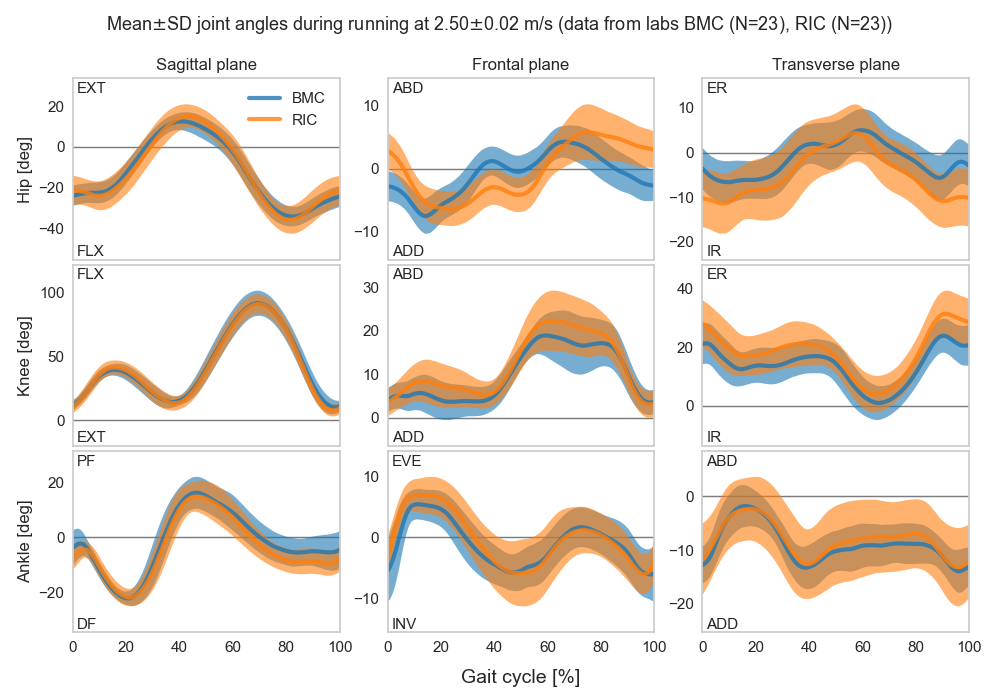

In [9]:
#@title #### Plot {display-mode: "form"}
tn = np.linspace(0, 100, 101)

fig, axs = plt.subplots(3, 3, figsize=(10, 7), sharex=True)
v_m, v_sd = meta_s.Speed.mean(), meta_s.Speed.std()
labs_s = [f'{lab} (N={len(meta_s[meta_s["Group"]==lab]["Group"])})' for lab in labs]
labs_s = ', '.join(labs_s)
fig.suptitle(f'Mean$\pm$SD joint angles during running at {v_m:,.2f}$\pm${v_sd:,.2f} m/s (data from labs {labs_s})', fontsize=13)
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        for l, lab in enumerate(labs):
            axs[j, xyz].axhline(y=0, color=[0, 0, 0, .3], linestyle='-', zorder=-1)
            axs[j, xyz].plot(tn, ang_m[:, 3*j+xyz, l], label=labs[l], color=colors[l], alpha=.8, lw=3)
            axs[j, xyz].fill_between(tn,
                                     ang_m[:, 3*j+xyz, l] + ang_sd[:, 3*j+xyz, l],
                                     ang_m[:, 3*j+xyz, l] - ang_sd[:, 3*j+xyz, l],
                                     facecolor=colors[l], alpha=.6, edgecolor='none')

        axs[j, xyz].set_ylabel(joint + '-' + planes[xyz])
        axs[j, xyz].set_xlim([0, 100])
        axs[j, xyz].margins(y=0.2)
        axs[j, xyz].grid(False)
        axs[j, xyz].xaxis.set_ticks_position('none')
        axs[j, xyz].yaxis.set_ticks_position('none')
        axs[j, xyz].tick_params(axis='both', which='major', pad=0)
        axs[j, xyz].text(.015, .92, f'{pos_angs[j][xyz]}', fontsize=11, transform=axs[j, xyz].transAxes)
        axs[j, xyz].text(.015, .02, f'{neg_angs[j][xyz]}', fontsize=11, transform=axs[j, xyz].transAxes)
        if j == 0:
            axs[0, xyz].set_title(f'{planes[xyz]} plane')
        if j == 2 and xyz == 1:
            axs[j, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
            axs[j, xyz].xaxis.set_label_coords(.5, -.2)
        if xyz == 0:
            axs[j, xyz].set_ylabel(f'{joint} [deg]')
        else:
            axs[j, xyz].set_ylabel('')

fig.align_ylabels(axs[:, 0])
axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.3, w_pad=.05)
try:
    fig.savefig(f'{path2}{os_sep}labs_angs.png', bbox_inches='tight')
except:
    print('Figure not saved in the cloud.')
plt.show()

## Descriptive statistics for angles

### Root-mean-square deviation (RMSD)

The root-mean-square deviation (RMSD) is the square root of the average of squared deviations between two samples $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$

### Relative root-mean-square deviation (RMSD rel)

The relative RMSD in percentage (RMSD rel) is the RMSD divided by the absolute mean (AM) between two samples $x$ and $y$ times 100, where AM is:

$$ \mathrm{AM} = \sum_{i=1}^N \frac{|x_i|+|y_i|}{2N} $$

### Absolute maximum difference (AMD)

The maximum difference (AMD) between two samples $x$ and $y$ is:

$$ \mathrm{AMD} = \max \{ |x-y| \} $$

### Relative absolute maximum difference (AMD rel)

The relative maximum difference in percentage (AMD rel) is the AMD divided by the absolute mean (AM) times 100.

In [10]:
#@title #### Table with results {display-mode: "form"}
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays
AMD  = lambda x, y: np.nanmax(np.abs(y - x), axis=0)  #  x and y must be arrays
AM   = lambda x: np.nanmean(np.nanmean(np.abs(x), axis=2), axis=0)  #  x must be 3d arrays
# inter-laboratory stats
rmsd = RMSD(ang_m[:, :, 0], ang_m[:, :, 1])
am = AM(ang_m)
rmsd_r = rmsd/am * 100
amd = AMD(ang_m[:, :, 0], ang_m[:, :, 1])
amd_r = amd/am * 100
# intra-lab stats
rmsd_i = np.sqrt(np.mean((ang_sd**2 * (nsubjects-1)/nsubjects), axis=0))
rmsd_i_rel = rmsd_i / np.nanmean(np.abs(ang_m), axis=0) * 100
stats = pd.DataFrame({'AMD [deg]': amd, 'AMD rel [%]': amd_r,
                      'RMSD [deg]': rmsd, 'RMSD rel [%]': rmsd_r},
                     index=angles2)
for l, lab in enumerate(labs):
    stats[f'RMSD_{lab} [deg]'] = rmsd_i[:, l]
    stats[f'RMSD_{lab} rel [%]'] = rmsd_i_rel[:, l]
stats['RMSD_All [deg]'] = np.mean(rmsd_i, axis=1)

display(stats.style.format('{:.1f}'))
print('')
display(stats.describe().T.style.format('{:.1f}'))

ttest = pg.ttest(stats['RMSD [deg]'], stats['RMSD_All [deg]'])
ttest.rename(index={'T-test': 'RMSD [deg]'}, inplace=True)
ttest.drop(columns=['alternative', 'BF10', 'power'], inplace=True)
ttest.index.name = 'Inter-Intra'
print('')
display(ttest)

,AMD [deg],AMD rel [%],RMSD [deg],RMSD rel [%],RMSD_BMC [deg],RMSD_BMC rel [%],RMSD_RIC [deg],RMSD_RIC rel [%],RMSD_All [deg]
Hip Sagittal,3.6,20.1,2.0,11.2,5.1,29.3,7.0,38.4,6.0
Hip Frontal,5.8,171.5,3.6,107.1,2.6,96.4,3.1,76.9,2.9
Hip Transverse,7.9,162.3,4.0,81.1,4.6,130.2,6.4,103.5,5.5
Knee Sagittal,3.9,9.4,1.7,4.0,7.6,18.1,6.7,16.3,7.2
Knee Frontal,4.2,39.1,2.4,22.5,4.3,43.7,4.7,39.7,4.5
Knee Transverse,8.9,56.0,5.0,31.6,6.0,44.3,6.9,37.9,6.4
Ankle Sagittal,4.0,41.2,2.4,24.5,5.5,59.2,5.3,52.4,5.4
Ankle Frontal,3.8,112.1,1.4,41.5,3.5,108.3,3.9,109.1,3.7
Ankle Transverse,1.9,21.9,1.1,12.5,3.6,40.7,6.5,80.3,5.1


,count,mean,std,min,25%,50%,75%,max
AMD [deg],9.0,4.9,2.2,1.9,3.8,4.0,5.8,8.9
AMD rel [%],9.0,70.4,62.3,9.4,21.9,41.2,112.1,171.5
RMSD [deg],9.0,2.6,1.3,1.1,1.7,2.4,3.6,5.0
RMSD rel [%],9.0,37.3,34.7,4.0,12.5,24.5,41.5,107.1
RMSD_BMC [deg],9.0,4.8,1.5,2.6,3.6,4.6,5.5,7.6
RMSD_BMC rel [%],9.0,63.4,38.8,18.1,40.7,44.3,96.4,130.2
RMSD_RIC [deg],9.0,5.6,1.4,3.1,4.7,6.4,6.7,7.0
RMSD_RIC rel [%],9.0,61.6,32.2,16.3,38.4,52.4,80.3,109.1
RMSD_All [deg],9.0,5.2,1.3,2.9,4.5,5.4,6.0,7.2


,T,dof,p-val,CI95%,cohen-d
Inter-Intra,,,,,
RMSD [deg],-4.119,16,8.033e-04,"[-3.91, -1.25]",1.942


The average variability inter-laboratories (RMSD = 2.6 deg) is lower than the variability intra-laboratories (RMSD BMC = 4.8 deg, RMSD RIC = 5.6 deg).

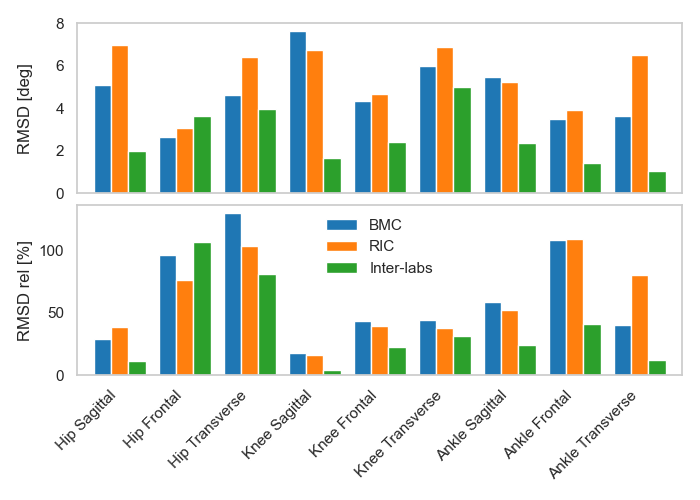

In [11]:
#@title #### Plot with results {display-mode: "form"}
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
stats.loc[:, ['RMSD_BMC [deg]', 'RMSD_RIC [deg]', 'RMSD [deg]']].plot.bar(ax=axs[0], width=.8, edgecolor=None, legend=False)
stats.loc[:, ['RMSD_BMC rel [%]', 'RMSD_RIC rel [%]', 'RMSD rel [%]']].plot.bar(ax=axs[1], width=.8, edgecolor=None)
axs[0].set_ylabel('RMSD [deg]')
axs[1].set_ylabel('RMSD rel [%]')
axs[1].set_xlabel('')
axs[1].set_xticklabels(angles2, rotation=45, ha='right')
axs[0].grid(False)
axs[1].grid(False)
fig.align_ylabels(axs)
legend = labs.copy()
legend.extend(['Inter-labs'])
axs[1].legend(legend, loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.2)
plt.show()

## Inference using Statistical Parametric Mapping (SPM)

Statistical Parametric Mapping uses random field theory to make statistical inferences regarding registered (normalized) sets of 1D measurements. See [https://spm1d.org/index.html](https://spm1d.org/index.html).

In [12]:
#@title #### SPM1d inferences {display-mode: "form"}
#fig, axs = plt.subplots(3, 3, sharex=True, figsize=(12, 5))
spm_t = np.empty((3, 3), dtype=np.object_)
spm_ti = spm_t.copy()
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        ang_bmc = ang_all[:, 3*j+xyz, :, 0].T
        ang_ric = ang_all[:, 3*j+xyz, :, 1].T
        spm_t[j, xyz]  = spm1d.stats.ttest2(ang_bmc, ang_ric, equal_var=False)
        spm_ti[j, xyz] = spm_t[j, xyz].inference(alpha=0.05, two_tailed=True, interp=True)
        print(joint, eixo, '\n', spm_ti[j, xyz])
        #spm_ti[j, xyz].plot(ax=axs[j, xyz])
        #spm_ti[j, xyz].plot_threshold_label(ax=axs[j, xyz], color='red')
        #spm_ti[j, xyz].plot_p_values(ax=axs[j, xyz], size=12)  # offset_all_clusters=(0.1, 0.4)

#fig.tight_layout(w_pad=.1)

Hip Z 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 40.631)
   SPM.fwhm      :  27.10754
   SPM.resels    :  (1, 3.68901)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.91925
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()



Hip X 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 43.245)
   SPM.fwhm      :  18.06163
   SPM.resels    :  (1, 5.53660)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  3.05908
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (0.006, <0.001, <0.001)



Hip Y 
 SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 40.437)
   SPM.fwhm      :  23.29359
   SPM.resels    :  (1, 4.29303)
Inference:
   SPM.alpha     :  0.050
   SPM.zstar     :  2.97677
   SPM.h0reject  :  True
   SPM.p_set     :  <0.001
   SPM.p_cluster :  (0.044, 0.017)



Knee Z 
 SPM{t} inf

### Plots of angles and SPM results

Figure not saved in the cloud.


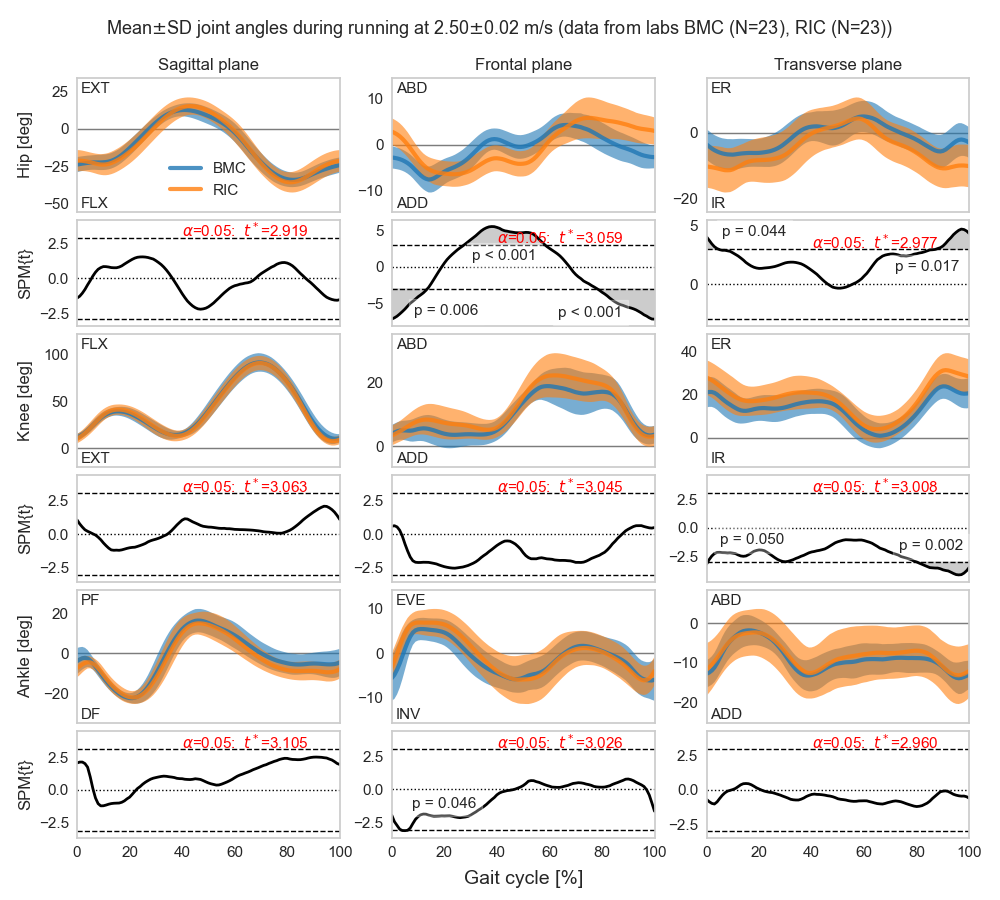

In [13]:
#@title #### Plot {display-mode: "form"}
tn = np.linspace(0, 100, 101)

# spm1d p-values offsets in plots
offsets = [[None, [(15, -1), (0, -3), (-15, -1)], [(16, 1), (-10, -2.5)]],
           [None, None, [(17, 2), (-5, 2)]],
           [None, [(15, +2)], None]]

heights = [1, .8, 1, .8, 1, .8]
widths  = [1, 1, 1]
fig, axs = plt.subplots(6, 3, figsize=(10, 9), sharex=True,
                        gridspec_kw={'height_ratios': heights, 'width_ratios': widths})
v_m, v_sd = meta_s.Speed.mean(), meta_s.Speed.std()
labs_s = [f'{lab} (N={len(meta_s[meta_s["Group"]==lab]["Group"])})' for lab in labs]
labs_s = ', '.join(labs_s)
fig.suptitle(f'Mean$\pm$SD joint angles during running at {v_m:,.2f}$\pm${v_sd:,.2f} m/s (data from labs {labs_s})', fontsize=13)
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        for l, lab in enumerate(labs):
            axs[2*j, xyz].axhline(y=0, color=[0, 0, 0, .3], linestyle='-', zorder=-1)
            axs[2*j, xyz].plot(tn, ang_m[:, 3*j+xyz, l], label=labs[l], color=colors[l], alpha=.8, lw=3)
            axs[2*j, xyz].fill_between(tn,
                                       ang_m[:, 3*j+xyz, l] + ang_sd[:, 3*j+xyz, l],
                                       ang_m[:, 3*j+xyz, l] - ang_sd[:, 3*j+xyz, l],
                                       facecolor=colors[l], alpha=.6, edgecolor='none')

        # spm1d plots
        spm_ti[j, xyz].plot(ax=axs[2*j+1, xyz], color='k', plot_ylabel=False)
        spm_ti[j, xyz].plot_threshold_label(ax=axs[2*j+1, xyz], size=11)
        spm_ti[j, xyz].plot_p_values(ax=axs[2*j+1, xyz], size=11, offsets=offsets[j][xyz])
        #axs[2*j+1, xyz].spines[:].set_color(None)

        axs[2*j, xyz].set_ylabel(joint + '-' + planes[xyz])
        axs[2*j, xyz].set_xlim([0, 100]), axs[2*j+1, xyz].set_xlim([0, 100])
        axs[2*j, xyz].margins(y=0.2)
        axs[2*j, xyz].grid(False), axs[2*j+1, xyz].grid(False)
        axs[2*j, xyz].xaxis.set_ticks_position('none'), axs[2*j+1, xyz].xaxis.set_ticks_position('none')
        axs[2*j, xyz].yaxis.set_ticks_position('none'), axs[2*j+1, xyz].yaxis.set_ticks_position('none')
        axs[2*j, xyz].text(.015,  .89, f'{pos_angs[j][xyz]}', fontsize=11, transform=axs[2*j, xyz].transAxes)
        axs[2*j, xyz].text(.015, .03, f'{neg_angs[j][xyz]}', fontsize=11, transform=axs[2*j, xyz].transAxes)
        axs[2*j, xyz].tick_params(axis='both', which='major', pad=0)
        axs[2*j+1, xyz].tick_params(axis='both', which='major', pad=0)
        if j == 0:
            axs[0, xyz].set_title(f'{planes[xyz]} plane')
        if j == 2 and xyz == 1:
            axs[2*j+1, xyz].set_xlabel('Gait cycle [%]', fontsize=14)
            axs[2*j+1, xyz].xaxis.set_label_coords(.5, -.3)
        if xyz == 0:
            axs[2*j, xyz].set_ylabel(f'{joint} [deg]', fontsize=12)
            axs[2*j+1, xyz].set_ylabel('SPM{t}', fontsize=12)
        else:
            axs[2*j, xyz].set_ylabel(''), axs[2*j+1, xyz].set_ylabel('')

fig.align_ylabels(axs[:, 0])
axs[0, 0].legend(loc='best', framealpha=1, frameon=False)
fig.tight_layout(h_pad=.3, w_pad=.05)
try:
    fig.savefig(f'{path2}{os_sep}labs_angs_spm.png', bbox_inches='tight')
except:
    print('Figure not saved in the cloud.')
plt.show()